In [1]:
import os
os.environ["PATH"] += ":/usr/local/texlive/2024/bin/universal-darwin"

import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from helpers import save_dict,load_dict
from plotting_helpers import add_energy_legends, add_gridlines, set_x_ticks

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 15,
    "font.family": "Helvetica"

})

column_width = 3.75
square_fig_size=(2*column_width,3/2*column_width)


# Helper Functions

In [3]:
def second_order(x, e1, e2, E_inf):
    return E_inf + e1 * x + e2 * x**2

In [4]:
def get_intercept_error(X, Y, slope):
    mean_x = np.mean(X)
    mean_y = np.mean(Y)
    intercept_ols = mean_y - slope * mean_x
    intercept_error_ols = np.std(Y - (slope * X + intercept_ols))
    return intercept_error_ols


# Load Data

In [5]:
Ls_1 = np.arange(6,21,2)
Ls_2 = np.arange(24,33,4)
Ls = np.concatenate((Ls_1,Ls_2),axis=0)

rates = [0.475, 0.25]
scales = [0.25,0.5,1.,2.,4.]

In [6]:
data = load_dict('./final_data/final_energy_data.pkl')
plotting_data = load_dict('./final_data/final_energy_data_plotting.pkl')
zero_var_energies = load_dict('./final_data/zero_var_energies.pkl')
reference_data = load_dict('./final_data/references.pkl')

# Plot

In [7]:
colorscale = plt.get_cmap('plasma')
shades = np.linspace(0.,0.9,len(scales)+1)[::-1][:-1]
colors = colorscale(shades)
markers = {0.475:'s',0.25:'8'}
markersizes = {0.475:6,0.25:8}
alphas = {0.475:0.5,0.25:1.0}
linestyles= {0.475:'--',0.25:'-'}
bigger_font_size = 22

## Open

### Energies

/Users/megan/miniconda3/envs/2DRNN/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/megan/miniconda3/envs/2DRNN/lib/python3.9/site-packages/numpy/ma/core.py:3375: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


RNN extrapolated zero-var energy (poly fit): -0.6694224774475628


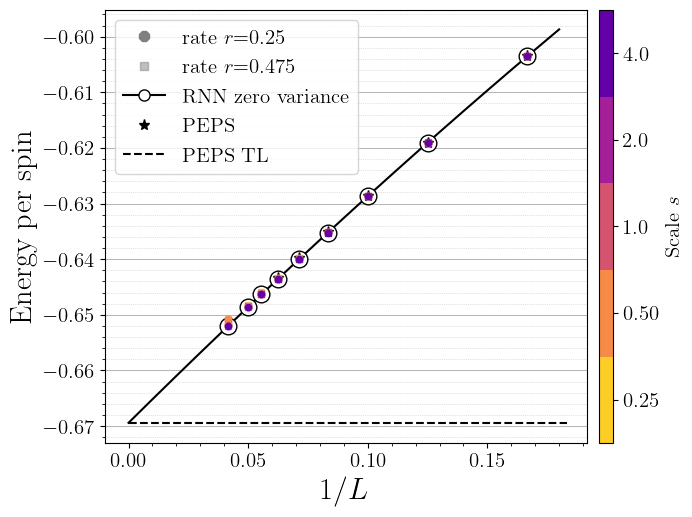

In [18]:
open_Ls = Ls[:-2] # only up to L=24

plt.figure(figsize=square_fig_size)
add_gridlines(axes='y')

show_zero_var = True
show_runs = True

bc = 'open'
data_ = data[bc]
plotting_data_ = plotting_data[bc]
ref_data_ = reference_data[bc]
scaling_power = ref_data_['scaling power']

zero_var_ens = zero_var_energies[bc]['energies bootstrapped']
zero_var_errs = zero_var_energies[bc]['energy errors bootstrapped']

bc = 'open'
ref_data_ = reference_data[bc]
ref_label = ref_data_['method']
ref_inf_energy = ref_data_['inf E']
reference_x = ref_data_['x']
reference_ens = ref_data_['energy']

x = 1/open_Ls**scaling_power

if show_zero_var:
    plt.errorbar(1/open_Ls[:]**scaling_power,zero_var_ens,yerr=zero_var_errs,
                marker='o',ms=12,fmt='o',capsize=0,
                mfc='white',mec='k',c='k',
                label='RNN, zero-variance')

plt.errorbar((1/reference_x**scaling_power),reference_ens,
        marker='*',ms=8,fmt='o',
        mfc='k',mec='k',c='k',
        label=ref_label)

if show_runs:
    for rate_i,rate in enumerate(rates):
        for scale_i, scale in enumerate(scales):
            plt.errorbar(1/plotting_data_[f"rate={rate}"][f"scale={scale}"]['ls']**scaling_power,
                         plotting_data_[f"rate={rate}"][f"scale={scale}"]['energies'],
                         yerr=plotting_data_[f"rate={rate}"][f"scale={scale}"]['std errors'],
                         marker=markers[rate],ms=5,fmt='o',capsize=0,
                         mfc=colors[scale_i],mec=colors[scale_i],c=colors[scale_i],alpha=alphas[rate],
                         label=f'{scale},{rate}')                

if show_zero_var:
    y = np.array(zero_var_ens)
    params, covariance = curve_fit(second_order, x, y)
    x_mesh = np.arange(0,1.1*max(x),0.01)
    plt.plot(x_mesh,
             second_order(x_mesh,params[0],params[1],params[2]),
             color='k',linestyle='-')
    print(f"RNN extrapolated zero-var energy (poly fit): {params[-1]}")

plt.hlines(ref_inf_energy,0,1.1*max(x),linestyle='--',color='k',label=ref_label+' TDL')

add_energy_legends(reference_label=ref_label,show_runs=show_runs,show_zero_var=show_zero_var)

plt.xlim(-0.01,1.15*max(x))
plt.ylabel('Energy per spin',fontsize=bigger_font_size)
plt.xlabel(f'$1/L$',fontsize=bigger_font_size)

filename = 'energies_open'
if show_runs:
    filename += '_all_runs'
if show_zero_var:
    filename += '_zero_var'        
plt.savefig('./final_figures/'+filename+'.pdf',bbox_inches='tight',pad_inches=0.1)

plt.show()

#### bootstrap extrapolation

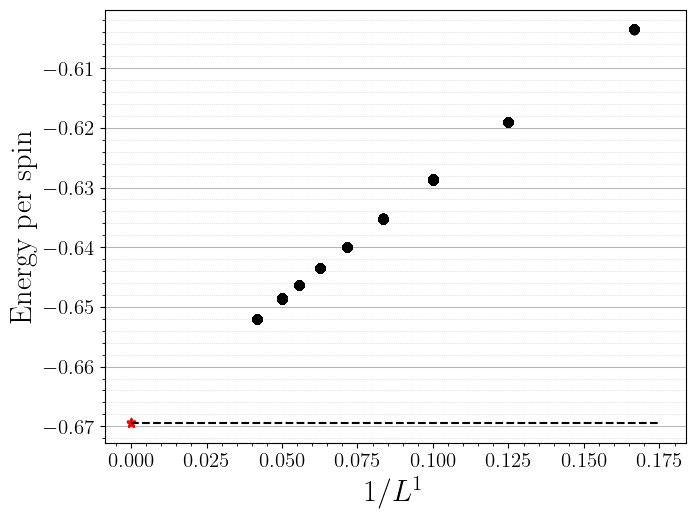

--------------------------------------------------
Getting y-int
--------------------------------------------------
y-int before:     -0.6694224774475628
y-int BOOTSTRAP:  -0.6694248814873707
err(y-int) BOOTSTRAP:  1.2428920776446884e-06


In [9]:
np.random.seed(100)
Nb = 1000

bc = 'open'
zero_var_ens = zero_var_energies[bc]['energies bootstrapped']
zero_var_errs = zero_var_energies[bc]['energy errors bootstrapped']

fig, ax = plt.subplots(figsize=square_fig_size)
add_gridlines(axes='y')

# Reproduce curve fit from above
x = 1/open_Ls**scaling_power
y = np.array(zero_var_ens)
params, covariance = curve_fit(second_order, x, y)

# Get residuals
xs = np.reshape(np.tile(1/open_Ls**scaling_power, Nb),(Nb,-1))
predicted_ys = second_order(x,params[0],params[1],params[2]) # using params from curve fit above
residuals = zero_var_ens - predicted_ys

# Get resampled y values
gaussian_vars = np.random.normal(loc=0.0,scale=1.0,size=(Nb,len(predicted_ys)))
resampled_ys = predicted_ys + residuals * gaussian_vars
ax.scatter(xs, resampled_ys, color='k')

# Perform fits through resampled data
intercepts = []
for b in range(Nb):
    xb = xs[b, :]
    yb = resampled_ys[b, :]
    paramsb, _ = curve_fit(second_order, xb, yb)
    intercepts.append(paramsb[-1])
    if b % 100 == 0:
        ax.scatter(0,paramsb[-1],marker='*',color='red')

intercepts = np.array(intercepts)

ax.hlines(ref_inf_energy,0,1.05*max(x),linestyle='--',color='k',label=ref_label+' TDL')
ax.set_ylabel('Energy per spin',fontsize=bigger_font_size)
ax.set_xlabel(f'$1/L^{scaling_power}$',fontsize=bigger_font_size)
plt.show()

print("-" * 50)
print("Getting y-int")
print("-" * 50)
print("y-int before:    ", params[-1])
print("y-int BOOTSTRAP: ", np.mean(intercepts))
print("err(y-int) BOOTSTRAP: ", np.std(intercepts)/np.sqrt(Nb))




### Variances

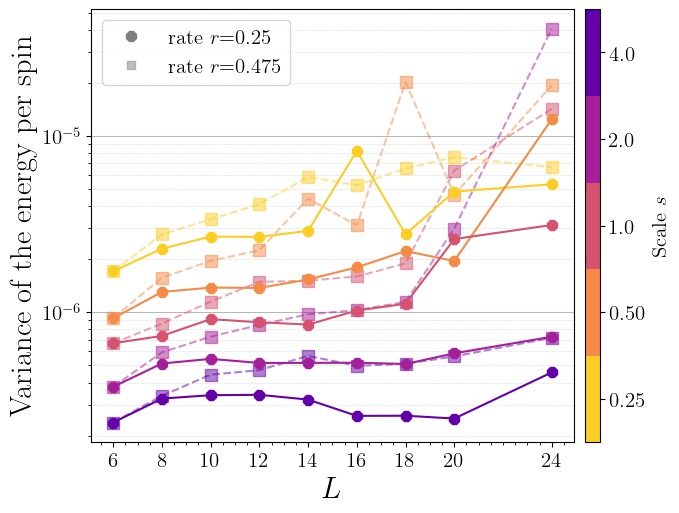

In [10]:
fig, ax = plt.subplots(figsize=square_fig_size)

bc = 'open'
data_ = data[bc]
plotting_data_ = plotting_data[bc]
ref_data_ = reference_data[bc]
scaling_power = ref_data_['scaling power']
ref_label = ref_data_['method']
ref_inf_energy = ref_data_['inf E']
reference_x = ref_data_['x']
reference_ens = ref_data_['energy']

for rate_i, rate in enumerate(rates):
    for scale_i, scale in enumerate(scales):
        plt.errorbar(plotting_data_[f"rate={rate}"][f"scale={scale}"]['ls'],
                        plotting_data_[f"rate={rate}"][f"scale={scale}"]['variances'],
                        marker=markers[rate],ms=8,fmt='o',c=colors[scale_i],
                        alpha=alphas[rate],linestyle=linestyles[rate],
                        label=f'{scale},{rate}')                

set_x_ticks(ax,cutoff=-2)
add_gridlines(axes='y')
add_energy_legends(show_runs=True)

plt.ylabel("Variance of the energy per spin",fontsize=bigger_font_size)
plt.xlabel("$L$",fontsize=bigger_font_size)
plt.yscale('log')

plt.savefig('./final_figures/variances_open.pdf',bbox_inches='tight',pad_inches=0.1)
plt.show()

## Periodic

### Energies

/Users/megan/miniconda3/envs/2DRNN/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/megan/miniconda3/envs/2DRNN/lib/python3.9/site-packages/numpy/ma/core.py:3375: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/Users/megan/miniconda3/envs/2DRNN/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/megan/miniconda3/envs/2DRNN/lib/python3.9/site-packages/numpy/ma/core.py:3375: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


RNN extrapolated zero-var energy: -0.6694890224842963 (error=0.0037936533764236073,score=0.9996952065945578)


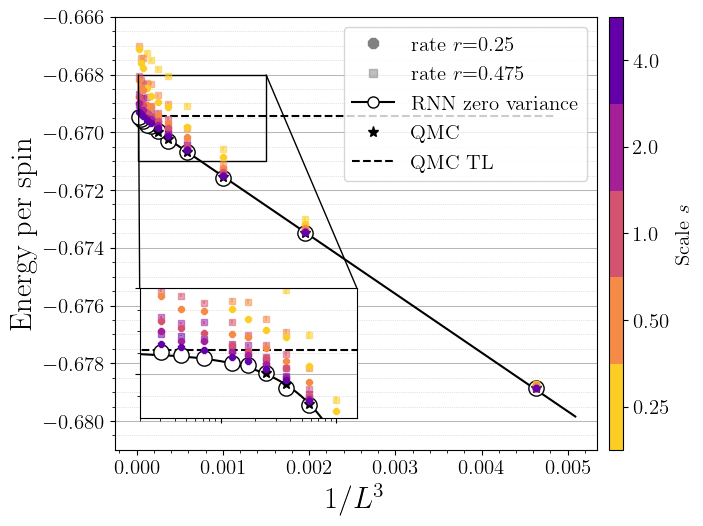

In [21]:
fig, ax = plt.subplots(figsize=square_fig_size)
add_gridlines(axes='y')

show_zero_var = True
show_runs = True
inset = True

bc = 'periodic'
data_ = data[bc]
plotting_data_ = plotting_data[bc]
ref_data_ = reference_data[bc]
scaling_power = ref_data_['scaling power']
ref_label = ref_data_['method']
ref_inf_energy = ref_data_['inf E']
reference_x = ref_data_['x']
reference_ens = ref_data_['energy']

zero_var_ens = zero_var_energies[bc]['energies bootstrapped']
zero_var_errs = zero_var_energies[bc]['energy errors bootstrapped']

x = 1/Ls**scaling_power

if show_zero_var:
    ax.errorbar(1/Ls**scaling_power,zero_var_ens, yerr=zero_var_errs,
            marker='o',ms=11,fmt='o',capsize=0,
            mfc='white',mec='k', color='k',
            label='RNN, zero-variance')

ax.errorbar((1/reference_x**scaling_power),reference_ens,
        marker='*',ms=8,fmt='o',
        mfc='k',mec='k',
        label=ref_label)

min_power = -4.7

if show_runs:
    for rate_i,rate in enumerate(rates):
        for scale_i, scale in enumerate(scales):
            plt.errorbar(1/plotting_data_[f"rate={rate}"][f"scale={scale}"]['ls']**scaling_power,
                         plotting_data_[f"rate={rate}"][f"scale={scale}"]['energies'],
                         yerr=plotting_data_[f"rate={rate}"][f"scale={scale}"]['std errors'],
                         marker=markers[rate],ms=5,fmt='o',capsize=0,
                         mfc=colors[scale_i],mec=colors[scale_i],c=colors[scale_i],alpha=alphas[rate],
                         label=f'{scale},{rate}')                

if show_zero_var:
    x_mesh = np.arange(0,1.1*max(x),1*10**min_power)
    reg_x = x[...,np.newaxis][:]
    reg_y = zero_var_ens[:]
    errs = zero_var_errs[:]
    reg = LinearRegression().fit(reg_x, reg_y) 
    score = reg.score(reg_x,reg_y)   
    err = get_intercept_error(reg_x,reg_y,reg.coef_)    

    ax.plot(x_mesh,reg.coef_*x_mesh+reg.intercept_,color='k',linestyle='-')
    print(f"RNN extrapolated zero-var energy: {reg.intercept_} (error={err},score={score})")


plt.hlines(ref_inf_energy,0,1.05*max(x),linestyle='--',color='k',label=ref_label+' TDL')
plt.ylim(-0.681, -0.666)  
plt.ylabel('Energy per spin',fontsize=bigger_font_size)
plt.xlabel(f'$1/L^{scaling_power}$',fontsize=bigger_font_size)
add_energy_legends(reference_label=ref_label,show_runs=show_runs,show_zero_var=show_zero_var)

if inset:

    inset = inset_axes(ax, width="45%", height="30%", loc="lower left", bbox_to_anchor=(0.03,0.05,1,1), bbox_transform=ax.transAxes)  # Width and height in % of the parent axes
    mark_inset(ax, inset, fc='none', ec="k", loc1=2, loc2=1, linewidth=1, zorder=1)

    if show_zero_var:
        inset.errorbar(1/Ls[:]**scaling_power,zero_var_ens, yerr=zero_var_errs,
                marker='o',ms=11,fmt='o',
                mfc='white',mec='k', color='k',
                label='RNN, zero-variance')

    inset.errorbar((1/reference_x**scaling_power),reference_ens,
            marker='*',ms=8,fmt='o',
            mfc='k',mec='k',
            label=ref_label)

    if show_runs:
        for rate_i,rate in enumerate(rates):
            for scale_i, scale in enumerate(scales):
                inset.errorbar(1/plotting_data_[f"rate={rate}"][f"scale={scale}"]['ls']**scaling_power,
                            plotting_data_[f"rate={rate}"][f"scale={scale}"]['energies'],
                            yerr=plotting_data_[f"rate={rate}"][f"scale={scale}"]['std errors'],
                            marker=markers[rate],ms=5,fmt='o',capsize=0,
                            mfc=colors[scale_i],mec=colors[scale_i],c=colors[scale_i],alpha=alphas[rate],
                            label=f'{scale},{rate}')                

    inset.set_xlim(10**min_power, 1.5*10**-3)
    inset.set_ylim(-0.671, -0.668)
    inset.set_xscale('log')
    if show_zero_var:
        inset.plot(x_mesh,reg.coef_*x_mesh+reg.intercept_,color='k',linestyle='-')
    inset.hlines(ref_inf_energy,0,1.05*max(x),linestyle='--',color='k',label=ref_label+' TDL')
    
    add_gridlines(axes='y')
    inset.set_xticklabels([])
    inset.set_yticklabels([])

filename = 'energies_peri'
if show_runs:
    filename += '_all_runs'
if show_zero_var:
    filename += '_zero_var'        
plt.savefig('./final_figures/'+filename+'.pdf',bbox_inches='tight',pad_inches=0.1)

plt.show()

#### bootstrap extrapolation

RNN extrapolated zero-var energy: -0.6694890224842963 (error=0.0037936533764236073)


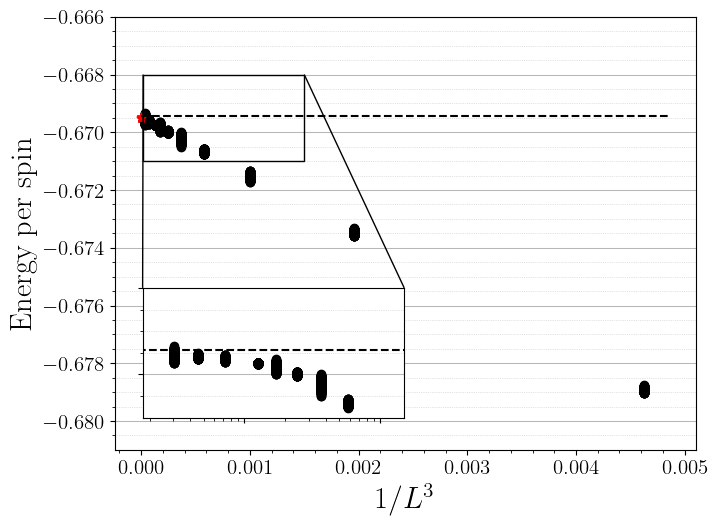

--------------------------------------------------
y-int estimates
--------------------------------------------------
y-int before:     -0.6694890224842963
y-int BOOTSTRAP:  -0.6694886355048418
err(y-int) before:     0.0037936533764236073
err(y-int) BOOTSTRAP:  5.260269090272142e-07


In [12]:
np.random.seed(100)
Nb = 1000

bc = 'periodic'
zero_var_ens = zero_var_energies[bc]['energies bootstrapped']
zero_var_errs = zero_var_energies[bc]['energy errors bootstrapped']

# Reproduce linear regression from above
x = 1/Ls**scaling_power
og_reg_x = x[...,np.newaxis][:]
og_reg_y = zero_var_ens[:]
og_reg = LinearRegression().fit(og_reg_x, og_reg_y) 
og_err = get_intercept_error(og_reg_x,og_reg_y,og_reg.coef_)    
print(f"RNN extrapolated zero-var energy: {og_reg.intercept_} (error={og_err})")

fig, ax = plt.subplots(figsize=square_fig_size)
add_gridlines(axes='y')
inset = inset_axes(ax, width="45%", height="30%", loc="lower left", bbox_to_anchor=(0.03,0.05,1,1), bbox_transform=ax.transAxes)  # Width and height in % of the parent axes
mark_inset(ax, inset, fc='none', ec="k", loc1=2, loc2=1, linewidth=1, zorder=1)

# Get Residuals
xs = np.reshape(np.tile(1/Ls**scaling_power, Nb),(Nb,-1))
predicted_ys = og_reg.coef_*x + og_reg.intercept_
residuals = zero_var_ens - predicted_ys

# Get resampled y values
gaussian_vars = np.random.normal(loc=0.0,scale=1.0,size=(Nb,len(predicted_ys)))
resampled_ys = predicted_ys + residuals * gaussian_vars
ax.scatter(xs, resampled_ys, color='k')
inset. scatter(xs, resampled_ys, color='k')

# Perform linear fits through resampled data
intercepts = []
for b in range(Nb):
    reg_x = xs[b,:][:,np.newaxis]
    reg_y = resampled_ys[b,:]
    regb = LinearRegression().fit(reg_x, reg_y)     
    intercepts.append(regb.intercept_)
    if b % 100 == 0:
        ax.scatter(0,regb.intercept_,marker='*',color='red')
        inset.scatter(0,regb.intercept_,marker='*',color='red')

intercepts = np.array(intercepts)

if inset:
    inset.set_xlim(10**-4.75, 1.5*10**-3)  # Optionally zoom into a region
    inset.set_ylim(-0.671, -0.668)  # Optionally zoom into a region
    inset.set_xscale('log')    
    add_gridlines(axes='y')
    inset.set_xticklabels([])
    inset.set_yticklabels([])
    inset.hlines(ref_inf_energy,0,1.05*max(x),linestyle='--',color='k',label=ref_label+' TDL')
    
ax.hlines(ref_inf_energy,0,1.05*max(x),linestyle='--',color='k',label=ref_label+' TDL')
ax.set_ylim(-0.681, -0.666)  # Optionally zoom into a region
ax.set_ylabel('Energy per spin',fontsize=bigger_font_size)
ax.set_xlabel(f'$1/L^{scaling_power}$',fontsize=bigger_font_size)
plt.show()

print("-" * 50)
print(f"y-int estimates")
print("-" * 50)
print("y-int before:    ", og_reg.intercept_)
print("y-int BOOTSTRAP: ", np.mean(intercepts))
print("err(y-int) before:    ", err)
print("err(y-int) BOOTSTRAP: ", np.std(intercepts)/np.sqrt(Nb))

In [13]:
## testing fits on different subsets of Ls

np.random.seed(100)
Nb = 1000

bc = 'periodic'
zero_var_ens = zero_var_energies[bc]['energies bootstrapped']
zero_var_errs = zero_var_energies[bc]['energy errors bootstrapped']

i_list = []
intercepts_i = []
intercepts_err_i = []

for i in range(len(Ls)-4):

    # Perform regression through certain energies
    x = 1/Ls**scaling_power
    reg_x_L = x[...,np.newaxis][i:]
    reg_y_L = zero_var_ens[i:]
    reg_L = LinearRegression().fit(reg_x_L, reg_y_L) 
    err_L = get_intercept_error(reg_x_L,reg_y_L,reg_L.coef_)    

    xs = np.reshape(np.tile(1/Ls**scaling_power, Nb),(Nb,-1))
    predicted_ys = reg_L.coef_*x + reg_L.intercept_
    residuals = zero_var_ens - predicted_ys

    # Get resampled y values
    gaussian_vars = np.random.normal(loc=0.0,scale=1.0,size=(Nb,len(predicted_ys)))
    resampled_ys = predicted_ys + residuals * gaussian_vars

    # Perform linear fits through resampled data
    intercepts = []
    for b in range(Nb):
        reg_x = xs[b,i:][:,np.newaxis]
        reg_y = resampled_ys[b,i:]
        regb = LinearRegression().fit(reg_x, reg_y)     
        intercepts.append(regb.intercept_)

    intercepts = np.array(intercepts)

    print("-" * 50)
    print(f"Getting y-int, min L in fit = {Ls[i]}")
    print("-" * 50)
    print("y-int before:    ", og_reg.intercept_)
    print("y-int BOOTSTRAP: ", np.mean(intercepts))
    print("err(y-int) before:    ", err)
    print("err(y-int) BOOTSTRAP: ", np.std(intercepts)/np.sqrt(Nb))
    i_list.append(Ls[i])
    intercepts_i.append(np.mean(intercepts))
    intercepts_err_i.append(np.std(intercepts)/np.sqrt(Nb))




--------------------------------------------------
Getting y-int, min L in fit = 6
--------------------------------------------------
y-int before:     -0.6694890224842963
y-int BOOTSTRAP:  -0.6694886355048418
err(y-int) before:     0.0037936533764236073
err(y-int) BOOTSTRAP:  5.260269090272142e-07
--------------------------------------------------
Getting y-int, min L in fit = 8
--------------------------------------------------
y-int before:     -0.6694890224842963
y-int BOOTSTRAP:  -0.6694711046195612
err(y-int) before:     0.0037936533764236073
err(y-int) BOOTSTRAP:  4.653677256427558e-07
--------------------------------------------------
Getting y-int, min L in fit = 10
--------------------------------------------------
y-int before:     -0.6694890224842963
y-int BOOTSTRAP:  -0.6694525408807955
err(y-int) before:     0.0037936533764236073
err(y-int) BOOTSTRAP:  3.7758383752068377e-07
--------------------------------------------------
Getting y-int, min L in fit = 12
--------------

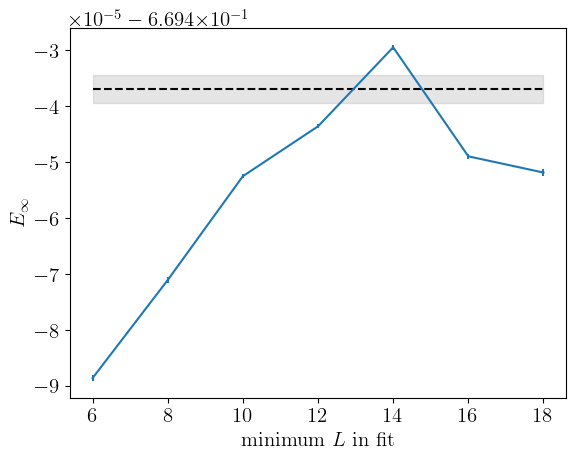

In [14]:
plt.errorbar(i_list,intercepts_i,yerr=intercepts_err_i)
plt.hlines(ref_inf_energy,min(i_list),max(i_list),linestyle='--',color='k',label=ref_label+' TDL')
plt.fill_between(i_list,np.ones(len(i_list))*(ref_inf_energy-2.5e-6),np.ones(len(i_list))*(ref_inf_energy+2.5e-6),color='grey',alpha=0.2)

plt.xlabel('minimum $L$ in fit')
plt.ylabel('$E_\infty$')
plt.show()

### Variances

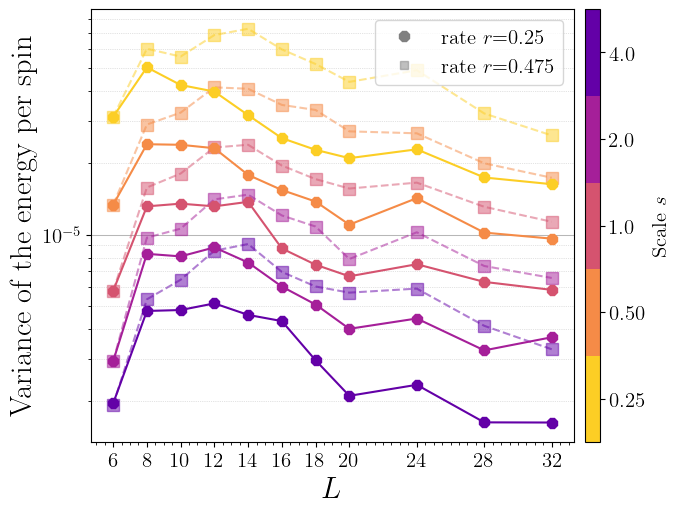

In [15]:

fig, ax = plt.subplots(figsize=square_fig_size)

bc = 'periodic'
data_ = data[bc]
plotting_data_ = plotting_data[bc]
ref_data_ = reference_data[bc]
scaling_power = ref_data_['scaling power']
ref_label = ref_data_['method']
ref_inf_energy = ref_data_['inf E']
reference_x = ref_data_['x']
reference_ens = ref_data_['energy']


for rate_i, rate in enumerate(rates):
    for scale_i, scale in enumerate(scales):
        plt.errorbar(plotting_data_[f"rate={rate}"][f"scale={scale}"]['ls'],
                        plotting_data_[f"rate={rate}"][f"scale={scale}"]['variances'],
                        marker=markers[rate],ms=8,fmt='o',c=colors[scale_i],
                        alpha=alphas[rate],linestyle=linestyles[rate],
                        label=f'{scale},{rate}')                

set_x_ticks(ax)
add_gridlines(axes='y')
add_energy_legends(show_runs=True)

plt.ylabel("Variance of the energy per spin",fontsize=bigger_font_size)
plt.xlabel("$L$",fontsize=bigger_font_size)
plt.yscale('log')

plt.savefig('./final_figures/variances_peri.pdf',bbox_inches='tight',pad_inches=0.1)
plt.show()